In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
words = open('../data/names.txt').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [9]:
for x,y in zip(Xtr[:10], Ytr[:10]):
  print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

... ---> y
..y ---> u
.yu ---> h
yuh ---> e
uhe ---> n
hen ---> g
eng ---> .
... ---> d
..d ---> i
.di ---> o


In [13]:
from typing import Any


class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 #Kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# ---------------------------------------------------------------------------------------
# we have to ensure that BatchNorm is in correct state, i.e. training or evaluation
# we couple the computation of the forward pass with the update of the running mean and variance
# we hhave to ensure tha mean and var reach steady state before we start using them
class BatchNorm1d:
    def __init__(self, dim, epsilon=1e-5, momentum=0.1):
        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.epsilon = epsilon
        self.momentum = momentum
        self.training = True
        # buffers (trained wiht a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.zeros(dim)

    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.epsilon)
        self.out = self.gamma * xhat + self.beta

        # update the running mean and variance
        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * xmean + (1-self.momentum) * self.running_mean
                self.running_var = self.momentum * xvar+ (1-self.momentum) * self.running_var
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

# ---------------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = x.tanh()
        return self.out
    def parameters(self):
        return []


In [14]:
torch.manual_seed(42) 

In [17]:
n_embd = 10
n_hidden = 200
C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(block_size*n_embd, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make it less confident

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [19]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mininbatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb  = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1) # concatenate vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())




      0/ 200000: 3.2968
  10000/ 200000: 2.0294
  20000/ 200000: 2.0240
  30000/ 200000: 2.0901
  40000/ 200000: 2.0693
  50000/ 200000: 2.1891
  60000/ 200000: 2.4997
  70000/ 200000: 2.2383
  80000/ 200000: 1.8810
  90000/ 200000: 2.1747
 100000/ 200000: 2.0060
 110000/ 200000: 2.0032
 120000/ 200000: 2.1458
 130000/ 200000: 2.2918
 140000/ 200000: 2.2601
 150000/ 200000: 2.4630
 160000/ 200000: 1.8900
 170000/ 200000: 2.2562
 180000/ 200000: 1.9334
 190000/ 200000: 2.5011


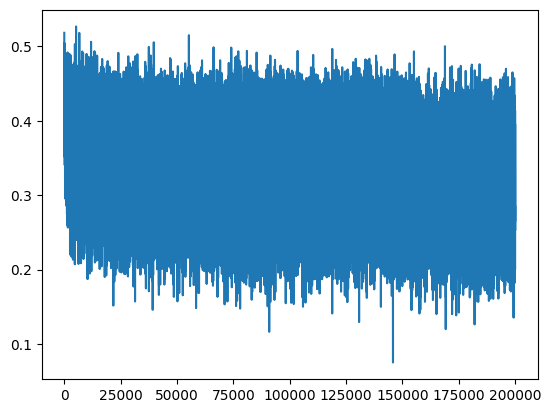

In [20]:
plt.plot(lossi)
# thick loss function due to small batch sizes

In [21]:
# put layers into eval mode
for layer in layers:
    layer.training = False

In [22]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.061211585998535
val 2.1094398498535156


In [23]:
# sample the model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=-1)
        # sampel form the distribution
        ix = torch.multinomial(probs[0], num_samples=1).item()
        # shift the context window
        context = context[1:] + [ix]
        out.append(ix)
        # skip if sample is speciual token
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

beaz.
yavayziciovevaner.
geulvon.
jose.
demy.
raisein.
jaylarmora.
weynahmi.
gent.
nah.
mayon.
afi.
quiodhannalysson.
arianna.
emildeton.
sab.
shael.
avidy.
natier.
yoyn.


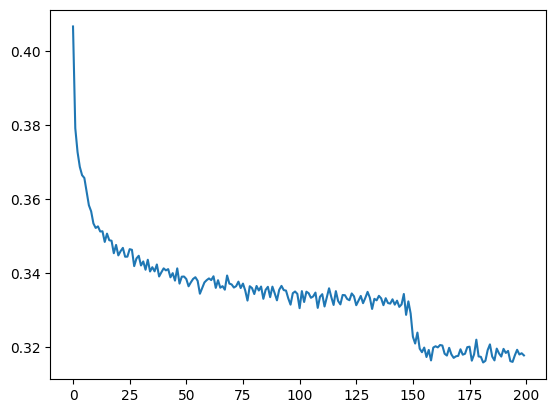

In [30]:
# let's improve the model
# if we look at the lossi, it wide we can  average it
# len(lossi) it has 200000 elements
#convert into shape of 200, 1000
torch.tensor(lossi).view(-1,1000).shape
# now take the mean along the rows and plot
plt.plot(torch.tensor(lossi).view(-1,1000).mean(dim=1))


Above is much better, we also see a sudden drop due to learning rate decay and then we mind local minimum

In [31]:
# now we update our forward pass, we
# we modularise the embedding and flattenning operations (emb = C[Xb]; x = emb.view(emb.shape[0], -1) # concatenate vectors) into a separate layer 
from typing import Any


class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 #Kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# ---------------------------------------------------------------------------------------
# we have to ensure that BatchNorm is in correct state, i.e. training or evaluation
# we couple the computation of the forward pass with the update of the running mean and variance
# we hhave to ensure tha mean and var reach steady state before we start using them
class BatchNorm1d:
    def __init__(self, dim, epsilon=1e-5, momentum=0.1):
        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.epsilon = epsilon
        self.momentum = momentum
        self.training = True
        # buffers (trained wiht a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.zeros(dim)

    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.epsilon)
        self.out = self.gamma * xhat + self.beta

        # update the running mean and variance
        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * xmean + (1-self.momentum) * self.running_mean
                self.running_var = self.momentum * xvar+ (1-self.momentum) * self.running_var
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

# ---------------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = x.tanh()
        return self.out
    def parameters(self):
        return []
# ---------------------------------------------------------------------------------------
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
# ---------------------------------------------------------------------------------------
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []
    

In [32]:
# now we change the layers
n_embd = 10
n_hidden = 200
# C = torch.randn((vocab_size, n_embd))
# add embedding and flatten layer
layers = [
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(block_size*n_embd, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make it less confident

# parameters = [C] + [p for layer in layers for p in layer.parameters()] # remove the C
parameters = [p for layer in layers for p in layer.parameters()]


print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [33]:
# simplyfy the forward and backward pass
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mininbatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb  = Xtr[ix], Ytr[ix]

    # forward pass
    #  emb = C[Xb] # this is removed as this is part of layers
    # x = emb.view(emb.shape[0], -1) # concatenate vectors
    x = Xb
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break


      0/ 200000: 3.2873


In [34]:
# pytorch also has a container called 'sequential' that passes the input through the layers in order
# we add that container to our model
# now we update our forward pass, we
# we modularise the embedding and flattenning operations (emb = C[Xb]; x = emb.view(emb.shape[0], -1) # concatenate vectors) into a separate layer 
from typing import Any


class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 #Kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# ---------------------------------------------------------------------------------------
# we have to ensure that BatchNorm is in correct state, i.e. training or evaluation
# we couple the computation of the forward pass with the update of the running mean and variance
# we hhave to ensure tha mean and var reach steady state before we start using them
class BatchNorm1d:
    def __init__(self, dim, epsilon=1e-5, momentum=0.1):
        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.epsilon = epsilon
        self.momentum = momentum
        self.training = True
        # buffers (trained wiht a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.zeros(dim)

    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.epsilon)
        self.out = self.gamma * xhat + self.beta

        # update the running mean and variance
        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * xmean + (1-self.momentum) * self.running_mean
                self.running_var = self.momentum * xvar+ (1-self.momentum) * self.running_var
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

# ---------------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = x.tanh()
        return self.out
    def parameters(self):
        return []
# ---------------------------------------------------------------------------------------
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
# ---------------------------------------------------------------------------------------
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []
# ---------------------------------------------------------------------------------------
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # get parameters in a list
        return [p for layer in self.layers for p in layer.parameters()]

In [46]:
# now we change the layers
n_embd = 10
n_hidden = 200

# change layers into Sequential contianer
model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(block_size*n_embd, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make it less confident

# parameters = [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()


print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


In [40]:
# also now we can simplify the forward pass and remove layers loop
# simplyfy the forward and backward pass
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mininbatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb  = Xtr[ix], Ytr[ix]

    # forward pass
    # replace the loop with model
    # x = Xb
    # for layer in layers:
    #     x = layer(x)
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())




      0/ 200000: 3.5096
  10000/ 200000: 2.3307
  20000/ 200000: 2.1527
  30000/ 200000: 2.6255
  40000/ 200000: 1.9085
  50000/ 200000: 2.0996
  60000/ 200000: 2.4145
  70000/ 200000: 2.0835
  80000/ 200000: 2.0566
  90000/ 200000: 2.0062
 100000/ 200000: 2.3070
 110000/ 200000: 2.0495
 120000/ 200000: 2.1166
 130000/ 200000: 1.7969
 140000/ 200000: 2.0017
 150000/ 200000: 2.3143
 160000/ 200000: 1.8750
 170000/ 200000: 2.1942
 180000/ 200000: 2.0381
 190000/ 200000: 2.0913


In [37]:
for layer in model.layers:
    layer.training = False

In [41]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    # emb = C[x]
    # x = emb.view(emb.shape[0], -1)
    # for layer in layers:
    #     x = layer(x)
    # replace the loop with model
    x = model(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.033113718032837
val 2.112365484237671


In [42]:
# simplify the sampling
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        # emb = C[torch.tensor([context])]
        # x = emb.view(emb.shape[0], -1)
        # for layer in layers:
        #     x = layer(x)
        # logits = x
        probs = F.softmax(logits, dim=-1)
        # sampel form the distribution
        ix = torch.multinomial(probs[0], num_samples=1).item()
        # shift the context window
        context = context[1:] + [ix]
        out.append(ix)
        # skip if sample is speciual token
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

azar.
sophyo.
devia.
layzahreen.
ania.
mirian.
lywanstohan.
amia.
tee.
nayla.
saad.
ain.
lorricki.
foyadry.
lynnelle.
ayijana.
eas.
apole.
adricklovi.
makarsto.


### Wavenet

Wavenet architecture combines individual characters into bi-grams which are then concatenated into 4-grams then into 8-grams forming a tree like structure. To implement wavenet, we make few changes
we increase context window to 8 characters and make model deeper

In [45]:
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182437, 8]) torch.Size([182437])
torch.Size([22781, 8]) torch.Size([22781])
torch.Size([22928, 8]) torch.Size([22928])


In [47]:
n_embd = 10
n_hidden = 200

# change layers into Sequential contianer
model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(block_size*n_embd, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make it less confident

# parameters = [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()


print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


### View the intermediate Tensors


In [57]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # lets look at the batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0, 18,  5, 13],
        [ 0,  0, 16,  1, 25,  4,  5, 14],
        [ 0,  0,  0,  0,  0,  0,  0, 13],
        [ 0,  0,  0,  0,  1, 10, 15, 21]])

In [58]:
# embedding layer output
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [59]:
model.layers[1].out.shape

torch.Size([4, 80])

In [60]:
model.layers[2].out.shape

torch.Size([4, 200])

In [65]:
# inside the Linear layer, (4,80) tensor is multiplied by (80,200) weight matrix and bias of shape (200,) gets added to it creating (4,200) tensor
(torch.randn(4,80) @ torch.randn(80,200) + torch.randn(200)).shape
# there is broadcastign happening
# this can be optimised, in pytorchon the left side of @, we can add a dimension , only the last dimension matters
# so we can add a dimension at the end of the tensor and process in parallel 
# (1 2) (3 4) (5 6) (7 8) convertin context window into bi-gram groups


# In the WAVENET, we don't want 80 characters to be multiplied by 200 weights, we want to 2 (2 of 10 dim = 20) characters together in the first layer
# if we join bi-grams then shape we want is (4, 4, 20) which is (batch_size, context/2, 10*2) instead of (4, 80)
(torch.randn(4,4, 20) @ torch.randn(20,200) + torch.randn(200)).shape

# now our goal is to change the Linear such such that  we  want 10-d vectors to get contactenated in pairs
# currently we have following 
e = torch.randn(4, 8, 10) # 4 examples, 8 characters, 10 dim embedding
e.view(e.shape[0], -1).shape # gives us (4, 80) tensor
# we want to convert it into (4, 4, 20) tensor
# we use python slicing to get the even and odd indices
list(range(10))[::2], list(range(10))[1::2]
e = torch.randn(4, 8, 10)
torch.cat([e[:,::2, :], e[:,1::2, :]], dim=2).shape # concatenate along the second dimension


torch.Size([4, 4, 20])

In [68]:
# we can also use view to reshape the tensor
e.view(4, 4, 20).shape

torch.Size([4, 4, 20])

In [88]:
# now update the liner layer to take care of flattening
# pytorch also has a container called 'sequential' that passes the input through the layers in order
# we add that container to our model
# now we update our forward pass, we
# we modularise the embedding and flattenning operations (emb = C[Xb]; x = emb.view(emb.shape[0], -1) # concatenate vectors) into a separate layer 
from typing import Any


class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 #Kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# ---------------------------------------------------------------------------------------
# we have to ensure that BatchNorm is in correct state, i.e. training or evaluation
# we couple the computation of the forward pass with the update of the running mean and variance
# we hhave to ensure tha mean and var reach steady state before we start using them
class BatchNorm1d:
    def __init__(self, dim, epsilon=1e-5, momentum=0.1):
        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.epsilon = epsilon
        self.momentum = momentum
        self.training = True
        # buffers (trained wiht a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.zeros(dim)

    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.epsilon)
        self.out = self.gamma * xhat + self.beta

        # update the running mean and variance
        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * xmean + (1-self.momentum) * self.running_mean
                self.running_var = self.momentum * xvar+ (1-self.momentum) * self.running_var
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

# ---------------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = x.tanh()
        return self.out
    def parameters(self):
        return []
# ---------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# ---------------------------------------------------------------------------------------
# class Flatten:
#     def __call__(self, x):
#         self.out = x.view(x.shape[0], -1)
#         return self.out
    
#     def parameters(self):
#         return []

class FlattenConsective: # pytorch flatten is different. we want to flatten consecutive elements
    # we want to flatten only some conssectuve elements and put them in the last dimension
    # for bi-grams, we want to concatenate 2 characters together
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n) # instead of -1 we use T//self.n
        if x.shape[1] == 1: # if we have only one element, we want to remove the dimension
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []

# ---------------------------------------------------------------------------------------
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # get parameters in a list
        return [p for layer in self.layers for p in layer.parameters()]

In [90]:
n_embd = 10
n_hidden = 200

# change layers into Sequential contianer
model = Sequential([
    Embedding(vocab_size, n_embd),
    # Flatten(),
    FlattenConsective(8),
    Linear(block_size*n_embd, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make it less confident

# parameters = [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()


print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


In [97]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # lets look at the batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)  
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0, 12,  1, 26,  9, 25,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [92]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsective : (4, 80)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [100]:
# now let's restructre for the hierarchical model
n_embd = 10
n_hidden = 68 # change to bing back the parameterst to 22k 

# change layers into Sequential contianer
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsective(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsective(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsective(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])


with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make it less confident

# parameters = [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

22397


In [101]:
# forward the model
ix = torch.randint(0, Xtr.shape[0], (4,)) # lets look at the batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)  
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  1, 25],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0, 22,  9, 11, 20],
        [ 0,  0,  0,  0, 23,  5, 25, 12]])

In [102]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsective : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsective : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsective : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [ ]:
# with hierarchical model we do't get much improvement
# we have to observe what is going on with BatchNorm
e = torch.randn(32, 4, 68)
emain = e.mean(0, keepdim=True) # 1,4,68

In [103]:
# run once for the Baseline
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mininbatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb  = Xtr[ix], Ytr[ix]

    # forward pass
    # replace the loop with model
    # x = Xb
    # for layer in layers:
    #     x = layer(x)
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.5256
  10000/ 200000: 2.6347
  20000/ 200000: 2.2540
  30000/ 200000: 2.2337
  40000/ 200000: 2.1550
  50000/ 200000: 1.8582
  60000/ 200000: 2.0627
  70000/ 200000: 2.5280
  80000/ 200000: 1.8906
  90000/ 200000: 2.0551
 100000/ 200000: 2.1491
 110000/ 200000: 1.9361
 120000/ 200000: 1.9601
 130000/ 200000: 2.0004
 140000/ 200000: 1.9889
 150000/ 200000: 1.7113
 160000/ 200000: 1.8086
 170000/ 200000: 2.0075
 180000/ 200000: 1.7466
 190000/ 200000: 1.8821


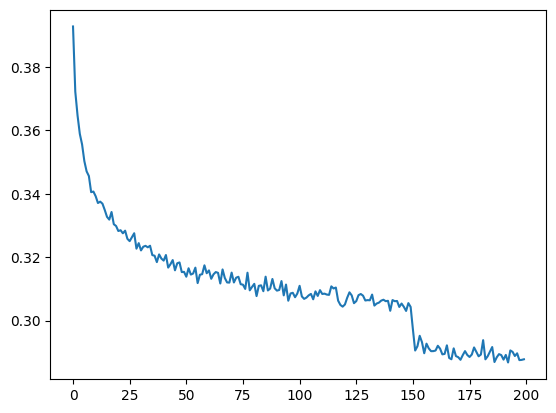

In [50]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(dim=1))


In [104]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    # emb = C[x]
    # x = emb.view(emb.shape[0], -1)
    # for layer in layers:
    #     x = layer(x)
    # replace the loop with model
    x = model(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9367245435714722
val 2.036116600036621


### performance log

- original (3 characters context  + 200 hidden neurons, 12K params): train: 2.03, val: 2.11
- context 3 -> 8 (22k params) train:1.918 and val: 2.033
- flat -> hierarchical (22k parameters): train:1.94 Val:2.036 (Batchnorm is not doing what it is supposed to do)